## Basic functions

In [1]:
import tensorflow as tf  # tf 2.x
import matplotlib.pyplot as plt
import math
import cmath
import numpy as np
from numpy.random import choice

try:
    import QGOpt as qgo
except ImportError:
    !pip install git+https://github.com/LuchnikovI/QGOpt
    import QGOpt as qgo

In [2]:
def matr_Ry(angle):
    return tf.constant([[math.cos(angle/2), -math.sin(angle/2)],
                        [+math.sin(angle/2), math.cos(angle/2)]], dtype=tf.complex64)

def matr_Rx(angle):
    return tf.constant([[math.cos(angle/2) + 0j, -1j * math.sin(angle/2)],
                        [-1j * math.sin(angle/2), math.cos(angle/2) + 0j]], dtype=tf.complex64)

def matr_Rz(angle):
    return tf.constant([[math.cos(angle/2) -1j * math.sin(angle/2), 0],
                        [0, math.cos(angle/2) + 1j * math.sin(angle/2)]], dtype=tf.complex64)

Hadamard = tf.constant([[1, 1],
                        [1, -1]], dtype=tf.complex64) / math.sqrt(2)

In [3]:
@tf.function
def kron(A, B):
    """
    Returns Kronecker product of two square matrices.

    Args:
        A: complex valued tf tensor of shape (dim1, dim1)
        B: complex valued tf tensor of shape (dim2, dim2)

    Returns:
        complex valued tf tensor of shape (dim1 * dim2, dim1 * dim2),
        kronecker product of two matrices
    """

    dim1 = A.shape[-1]
    dim2 = B.shape[-1]
    AB = tf.transpose(tf.tensordot(A, B, axes=0), (0, 2, 1, 3))
    return tf.reshape(AB, (dim1 * dim2, dim1 * dim2))

In [4]:
def reveal_cal_parameters(M):
    angle = cmath.phase(M[1, 0]) 
    flipped = True if (tf.math.imag(M[1, 1]) < 0) else False
    return angle, flipped

def get_more_precise_angle(M):
    angles = []
    angles.append(cmath.phase(M[1, 0]))
    angles.append(cmath.phase(-M[1, 3]))
    angles.append(cmath.phase(-M[0, 2] * 1j))
    angles.append(cmath.phase(M[3, 2] * 1j))
    angles.append(-cmath.phase(M[2, 0]))
    angles.append(-cmath.phase(-M[2, 3]))
    angles.append(-cmath.phase(M[0, 1] * 1j))
    angles.append(-cmath.phase(-M[3, 1] * 1j))
    angles.append(cmath.phase(-M[1, 2] * 1j)/2)
    angles.append(-cmath.phase(M[2, 1] * 1j)/2)
    #print(angles)
    return np.mean(angles)

def rotate_set(M_set, angle, flip):
    if (flip == True): #Remember, in flipped scenario angle comes with '-' sign
        M_set = np.conj(M_set) #but if U = [Rz1 @ U0* @ Rz2] that means U* = [Rz1* @ U0 @ Rz2*] and angles here are reversed too
    new_M_set = tf.concat([matr_Rz(angle) @ M_set[i] @ matr_Rz(-angle) [tf.newaxis] for i in np.arange(0, len(M_set))], axis=0)
    return new_M_set    

def calibrate_set(M_set):
    A = M_set[0] @ M_set[1]
    AxA = 2 * kron(A, tf.math.conj(A)) #AxA actually means AxA*
    angle0, flip = reveal_cal_parameters(AxA)
    if (flip): 
        AxA = tf.math.conj(AxA)
    angle1 = get_more_precise_angle(AxA) #angle is reversed if we need to complex conjugate because we made CONJ on UxU 
    #CONJ on flipped UxU* is CONJ on ([Rz1 @ U0* @ Rz2] x [Rz1* @ U0 @ Rz2*]]) = [Rz1* @ U0 @ Rz2*] x [Rz1 @ U0* @ Rz2]]
    #Because the procedure is trained on U0, this is easier but yields a minus sign
    
    #print(angle1, flip) 

    #Solution: one more "if" which makes angle1 = -angle1 if (flip). It is for the weak AND does not work properly
    new_U_set = rotate_set(M_set, angle1, flip) #the strong account for reversed angle inside calibration function  
    return new_U_set

In [5]:
pure_unitary_set = tf.concat([Hadamard[tf.newaxis],
                                  matr_Rz(math.pi/2)[tf.newaxis],
                                  matr_Rz(math.pi/4)[tf.newaxis]], axis=0)

#matr_Rz(math.pi/2.8)[tf.newaxis],
#matr_Rz(math.pi/4.1)[tf.newaxis]

"""
This is a "pure" set of gates which exist in our mathematical model.
They are considered pure in a sense that they have no noise at all. 
Any circuits the user runs on his quantum computer must contain only gates described here.
However, due to imperfectons his version of the same set can be different.
Futhermore, in the future versions we should note that each qubit can have its own "noised" versions. 
"""

'\nThis is a "pure" set of gates which exist in our mathematical model.\nThey are considered pure in a sense that they have no noise at all. \nAny circuits the user runs on his quantum computer must contain only gates described here.\nHowever, due to imperfectons his version of the same set can be different.\nFuthermore, in the future versions we should note that each qubit can have its own "noised" versions. \n'

In [6]:
def build_circuit_state_from_map(circ_map, gate_set):
    """
    Returns a quantum state which is obtained after "pulling" state |0> through a circuit.
    Because circuits consist of one-qubit gates, we can multiply matrices on a |0> state one by one.
    
    Args:
        circ_map: is an array of ints defining our circuit.
        Since we have a fixed set of gates, each gate is defined by an integer.
        
        gate_set: is a set of gates we use to build a circuit upon.
        Each gate is a 2x2 complex-valued matrix and can be adressed as gate_set[gate_id]
        
    Returns:
        in_state: the final state we get after circuit (|psi> = Un * ... * U1 |0>) 
    """
    
    in_state = tf.constant([1, 0], dtype=tf.complex64)
    for gate_id in circ_map[::-1]:
        in_state = tf.tensordot(gate_set[gate_id], in_state, axes=1)
    return in_state

In [7]:
PauliY = tf.constant([[0 + 0j, -1j],
            [1j, 0 + 0j]], dtype=tf.complex64)
PauliX = tf.constant([[0 + 0j, 1 + 0j],
              [1 + 0j, 0 + 0j]], dtype=tf.complex64)
PauliZ = tf.constant([[1 + 0j, 0 + 0j],
              [0 + 0j, -1 + 0j]], dtype=tf.complex64)
E = tf.eye(2, dtype=tf.complex64)

def wrong_unitary(M):
    pE = tf.dtypes.complex(tf.random.uniform([], -0.2, 0.2, dtype=tf.dtypes.float32, seed=123), 0.0)
    pX = tf.dtypes.complex(tf.random.uniform([], -0.1, 0.1, dtype=tf.dtypes.float32, seed=123), 0.0)
    pY = tf.dtypes.complex(tf.random.uniform([], -0.1, 0.1, dtype=tf.dtypes.float32, seed=123), 0.0)
    pZ = tf.dtypes.complex(tf.random.uniform([], -0.1, 0.1, dtype=tf.dtypes.float32, seed=123), 0.0)
    print ("Noising is made by exp(iH) @ U; H =",round(float(pE), 5) ,"E +",round(float(pX), 5), "X +",round(float(pY), 5), "Y +",round(float(pZ), 5),"Z")
    H = pE * E + pX * PauliX + pY * PauliY + pZ * PauliZ
    return tf.linalg.expm(H * 1j) @ M 

def roll_noising_parameters(seed1):
    pE = tf.dtypes.complex(tf.random.uniform([], -0.4, 0.4, dtype=tf.dtypes.float32, seed=seed1), 0.0)
    pX = tf.dtypes.complex(tf.random.uniform([], -0.2, 0.2, dtype=tf.dtypes.float32, seed=seed1), 0.0)
    pY = tf.dtypes.complex(tf.random.uniform([], -0.2, 0.2, dtype=tf.dtypes.float32, seed=seed1), 0.0)
    pZ = tf.dtypes.complex(tf.random.uniform([], -0.2, 0.2, dtype=tf.dtypes.float32, seed=seed1), 0.0)

    return pE, pX, pY, pZ

def wrong_unitary_fixed(M, pE_fix, pX_fix, pY_fix, pZ_fix):
    #print ("Noising is made by exp(iH) @ U; H =",round(float(pE_fix), 5) ,"E +",round(float(pX_fix), 5), "X +",round(float(pY_fix), 5), "Y +",round(float(pZ_fix), 5),"Z")
    H = pE_fix * E + pX_fix * PauliX + pY_fix * PauliY + pZ_fix * PauliZ
    return tf.linalg.expm(H * 1j) @ M 

def wrong_unitaries_random(pure_unitary_set):
    new_set = tf.concat([wrong_unitary(pure_unitary_set[i])[tf.newaxis] for i in range (pure_unitary_set.shape[0])], axis=0)
    return new_set

In [8]:
tf.random.set_seed(2228)

In [9]:
pE_fix, pX_fix, pY_fix, pZ_fix = roll_noising_parameters(228)

## Classes

In [10]:
class MeasurementData:
    """
    This is a class which describes the situation on the user's quantum PC.
    It contains some of the information the user should give us (e. g. samples).
    Also this class contains the information we should have no knowledge about (e.g. hidden_set).
    However, it is used just for sample generation purposes and is not used in the algorithm. 
    
    Attributes:
        hidden_set: is a set of gates the user has in their quantum computer.
        They are the "real" versions of gates, and can be considered as our aim.
        After some iterations of optimizers, we want our gates to be almost like "real" versions.
        Again, each gate is a 2x2 complex-valued matrix.
        
        noisy_gate: in our test model, one of our gates is bluntly replaced by Id matrix.
        The number defines which one was replaced. 
        
        samples: a huge 2D array of bits. Let us have M circuits and N runs of each. 
        The 'samples' array will be of shape (M, N), containing measurement results.
        For each of M circuits, N runs are made and measured, yielding 0 or 1 in the end.        
        
    Functions:
        generate_samples: The procedure of generating N outputs after N runs of all circuits.
        init_gates: The procedure of applying some kind of a noise to simulate user's noised version of gates [demo]
    """
       
    def __init__(self, circs_map, noisy_gate, pure_unitary_set):
        self.hidden_set = None
        self.noisy_gate = noisy_gate
        self.init_gates(self.noisy_gate, pure_unitary_set)
        
        self.samples = None
        self.generate_samples(circs_map, self.hidden_set, 10000)
        
    def generate_samples(self, circs_map, gate_set, smpl_size=10000):
        """
        Generates samples for each circuit depicted in a 'circs_map' array.
        Uses 'gate_set' to transform map of ints into actal gates and build a state upon them
        
        Args:
            circ_maps: is a list of arrays of ints, each array defining one of our circuits.
        
            gate_set: is a set of gates we use to build a circuit.
        
            smpl_size: number of measurements made per one circuit.
        
        Returns:
            actually does not return anything, but generates 'samples' for an instance of class.
            'samples' is a big 2D array, see class description.
        """
        samples = []
        for circ_map in circs_map:
            state = build_circuit_state_from_map(circ_map, gate_set)
            log_probs = tf.math.log(tf.abs(state) ** 2)
            eps = -tf.math.log(-tf.math.log(tf.random.uniform((smpl_size, 2)))) #OMG
            samples.append(tf.argmax(log_probs + eps, axis = -1))
        self.samples = samples
        
    def init_gates(self, noisy_id, pure_unitary_set):
        """
        Initializes "true" versions of noised gates. WIP.
        
        Args:
            pure_unitary_set: the "ideal" set we change a bit to create noised version.
        
            noisy_id: the gate we tinker with so it's made different from the "ideal" one.
        
        Returns:
            actually does not return anything, but generates 'hidden_set' for an instance of class.
        """
        if (noisy_id == 777):
            self.hidden_set = wrong_unitaries_random(pure_unitary_set)        
        elif (noisy_id == -1):
            self.hidden_set = tf.identity(pure_unitary_set) 
        else:
            noisy_gate = wrong_unitary_fixed(pure_unitary_set[noisy_id], pE_fix, pX_fix, pY_fix, pZ_fix)
            self.hidden_set = tf.concat([pure_unitary_set[:noisy_id],
                               noisy_gate[tf.newaxis],
                               pure_unitary_set[noisy_id+1:]], axis=0)

In [11]:
class Circuits:
    """
    This is a class which contains everything we need to run the program.
    
    Attributes:
        ideal_set: is a 'pure' set of gates which exist in our mathematical model.
            The gates are considered pure in a sense that they have no noise at all. 
            Any circuits the user runs on their quantum computer must contain only gates described here.
            However, due to imperfectons user's version of the same set can be different.
    
        workspace_set: is a set of gates we work with.
            These gates are initialized as an 'ideal_set'. 
            However, iteration-by-iteration they are tuned to be closer and closer to 'real' noised versions.
            IMPORTANT: these matrices are real-valued but contain one extra dimension.
            So we can perceive them as a 2x2x2 matrices (last dim is for 'Im' part and 'Re' part)
        
        map: is a 2D array of ints. Each row demonstrates a different circuit.
        In the row, each int encodes the gate number in the set.
        Thus, the sequence of gates in a circuit is encoded as a sequence of ints in an array.       
        
    Functions:
        complex_workspace: yields 'workspace_set' in a more convenient 2x2 complex matrix form.
    
        build_circuit_states_from_map: Essentially a 'build_circuit_state_from_map' for all the circuits.          
            Converts the 'map' array to an array of quantum states, representing how circuits acted on a state |0>.
        
        train_optimizer: Trains an optimizer passed in the function.
            Also yields a list of 'loss' values per iteration.
    """
    
    def __init__(self, circs_map, pure_unitary_set):
        workspace_set = tf.identity(pure_unitary_set)
        workspace_set = qgo.manifolds.complex_to_real(workspace_set)
        self.workspace_set = tf.Variable(workspace_set)
        self.ideal_set = tf.identity(pure_unitary_set)
        
        self.map = circs_map    
        
    def build_circuit_states_from_map(self, complex_gate_set):
        """
        Basically a 'build_circuit_state_from_map' function in a cycle, making states
        for all of the circuits simultaneously.
        """
        states = []
        for circ_map in self.map:
            circuit_state = build_circuit_state_from_map(circ_map, complex_gate_set)
            states.append(circuit_state)
        return states
    
    def init_workspace(self, pure_unitary_set):
        self.workspace_set = tf.Variable(qgo.manifolds.complex_to_real(pure_unitary_set))
    
    def complex_workspace(self):
        return qgo.manifolds.real_to_complex(self.workspace_set)
            
    @tf.function
    def _loss_and_grad(self, user_data_object, lmbd):
        """
        Do not touch! it works!
        """
        with tf.GradientTape() as tape:
            complex_set = qgo.manifolds.real_to_complex(self.workspace_set)
            states = self.build_circuit_states_from_map(complex_set)
    
            total_logp = tf.constant(0, dtype=tf.float32)
            for sample, psi in zip(user_data_object.samples, states):
                logp = tf.math.log(tf.abs(psi) ** 2)
                logp = tf.math.real(tf.reduce_mean(logp * tf.one_hot(sample, 2)))
                total_logp += logp
            reg = tf.math.real(lmbd * tf.linalg.norm(complex_set - self.ideal_set) ** 2)
            loss = -total_logp + reg
    
            grad = tape.gradient(loss, self.workspace_set)
            #grad = tf.gradients(loss, gate_set_real)
        return loss, grad
    
    def train_optimizer(self, opt, user_data_object, lmbd, iters):
        # this list will be filled by value of
        # error per iteration
        loss_dynamics = []

        # optimization loop
        for _ in range(iters):
            loss, grad = self._loss_and_grad(user_data_object, lmbd)
            #print(loss, grad)
            
            # filling list with history of error
            loss_dynamics.append(loss)
            # optimization step
            opt.apply_gradients(zip([grad], [self.workspace_set]))
        return loss_dynamics

## Initialization

In [12]:
m = qgo.manifolds.StiefelManifold()

In [13]:
circuits_map1 = []
"""
in the 1-qubit case it is basically a sequence of 1D arrays
this will be modified later into a 2D array
in multi-qubit version something smarter than just an array should be implemented
"""
'''circuits_map1.append([0, 1, 3])
circuits_map1.append([0, 3, 2])
circuits_map1.append([0, 1, 2])
circuits_map1.append([2, 0, 3, 1])
circuits_map1.append([0, 1, 3, 3])
circuits_map1.append([2, 0, 2, 1])
circuits_map1.append([3, 2, 5, 3])'''
#circuits_map1 = [tf.random.categorical(tf.math.log(tf.ones((1, 3)) / 3), 3)[0].numpy() for i in range(3)] +\
                #[tf.random.categorical(tf.math.log(tf.ones((1, 3)) / 3), 4)[0].numpy() for i in range(3)] +\
                #[tf.random.categorical(tf.math.log(tf.ones((1, 3)) / 3), 5)[0].numpy() for i in range(3)]

circuits_map1 = [tf.random.categorical(tf.math.log(tf.ones((1, 3)) / 3), 5)[0].numpy() for i in range(3)]
circuits_map2 = [tf.random.categorical(tf.math.log(tf.ones((1, 3)) / 3), 5)[0].numpy() for i in range(6)]
circuits_map3 = [tf.random.categorical(tf.math.log(tf.ones((1, 3)) / 3), 5)[0].numpy() for i in range(11)]

In [14]:
c1 = Circuits(circuits_map1, pure_unitary_set)
c2 = Circuits(circuits_map2, pure_unitary_set)
c3 = Circuits(circuits_map3, pure_unitary_set)

In [15]:
noisy_gate1 = 1
user_data1 = MeasurementData(circuits_map1, noisy_gate1, pure_unitary_set)
user_data2 = MeasurementData(circuits_map2, noisy_gate1, pure_unitary_set)
user_data3 = MeasurementData(circuits_map3, noisy_gate1, pure_unitary_set)

## Working with the optimizer

In [16]:
iterations = 750
lmbd = 0.3
lr = 0.05

In [17]:
opt1 = qgo.optimizers.RAdam(m, lr)
c1.init_workspace(pure_unitary_set)
loss_dynamics1 = c1.train_optimizer(opt1, user_data1, lmbd, iterations)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

In [18]:
opt2 = qgo.optimizers.RAdam(m, lr)
c2.init_workspace(pure_unitary_set)
loss_dynamics2 = c2.train_optimizer(opt2, user_data2, lmbd, iterations)

In [19]:
opt3 = qgo.optimizers.RAdam(m, lr)
c3.init_workspace(pure_unitary_set)
loss_dynamics3 = c3.train_optimizer(opt3, user_data3, lmbd, iterations)

In [20]:
def print_loss_dyn(loss_dynamics, num):
    plt.plot(loss_dynamics, label = num)
    plt.yscale('log')
    plt.xlabel('iter')
    plt.ylabel('err')
    plt.legend()
    return

In our model we need to get logarithm of probability that we got the correct gates. Since this is calculated via multiplication of probabilities to obtain each sample, we can just sum the ln(probability[i-th sample]) for i = 0..999.
The probability itself is easy to check since our final operator is a product of 2x2 matrices multilpication. Then we just look at <sample_bit| (u0 @ u1 @ ... @ uN) |0> which is the same as abs of the matrix element 

Text(0, 0.5, 'err')

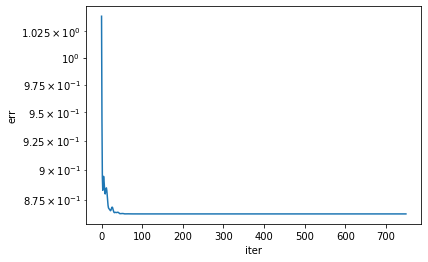

In [21]:
plt.plot(loss_dynamics1)
plt.yscale('log')
plt.xlabel('iter')
plt.ylabel('err')

C:\Users\1337pocan\anaconda3\envs\tf\lib\site-packages\numpy\core\_asarray.py:136: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


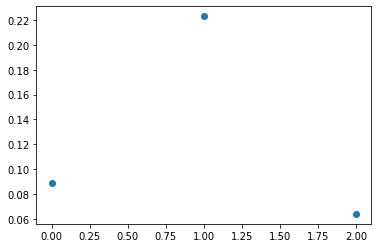

In [22]:
plt.scatter(tf.constant([0, 1, 2,]), tf.linalg.norm(c1.complex_workspace() - c1.ideal_set, axis=(-2, -1)))

Text(0, 0.5, 'err')

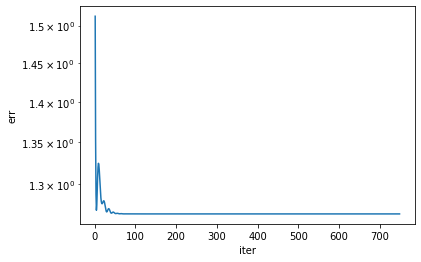

In [23]:
plt.plot(loss_dynamics2)
plt.yscale('log')
plt.xlabel('iter')
plt.ylabel('err')

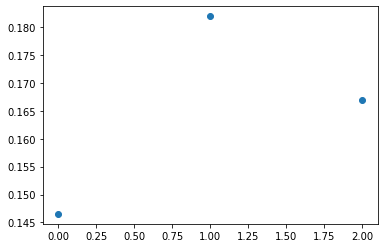

In [24]:
plt.scatter(tf.constant([0, 1, 2,]), tf.linalg.norm(c2.complex_workspace() - c2.ideal_set, axis=(-2, -1)))

Text(0, 0.5, 'err')

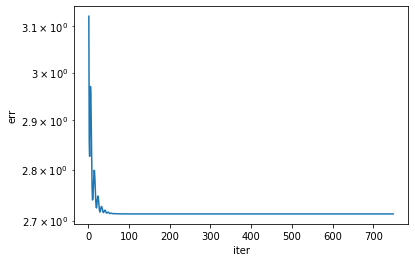

In [25]:
plt.plot(loss_dynamics3)
plt.yscale('log')
plt.xlabel('iter')
plt.ylabel('err')

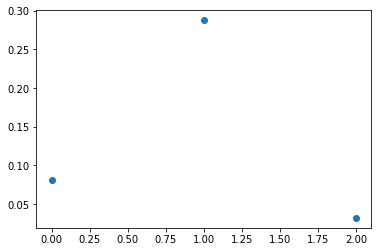

In [26]:
plt.scatter(tf.constant([0, 1, 2,]), tf.linalg.norm(c3.complex_workspace() - c3.ideal_set, axis=(-2, -1)))

## Obtaining results for Zhenya (BYDLOCODE)

In [27]:
def RunExperiment (runs=10, circ_number=3, noisy_gate=0):
    norms_list = None
    last_iter_list = []
    
    for iter in range(runs):
        circuits_map_test = [tf.random.categorical(tf.math.log(tf.ones((1, 3)) / 3), 6)[0].numpy() for i in range(circ_number)]
        c_test = Circuits(circuits_map_test, pure_unitary_set)
        user_data_test = MeasurementData(circuits_map_test, noisy_gate, pure_unitary_set)
    
        opt_test = qgo.optimizers.RAdam(m, lr)
        c_test.init_workspace(pure_unitary_set)
        _ = c_test.train_optimizer(opt_test, user_data_test, lmbd, iterations)
        
        last_iter_list.append(c_test.complex_workspace())
        
        #print ('iter ', iter)
        #print ('circuits_map', circuits_map_test)
    
    norms_list = tf.concat([tf.linalg.norm(last_iter_list[i] - c_test.ideal_set, axis=(-2, -1))[tf.newaxis] for i in range(runs)], axis=0)
    return norms_list

In [28]:
ng = 1
tf.random.set_seed(228)

In [29]:
def tf_count(t, val):
    elements_equal_to_value = tf.equal(t, val)
    as_ints = tf.cast(elements_equal_to_value, tf.int32)
    count = tf.reduce_sum(as_ints)
    return count

In [30]:
def my_norm(M1, M2):
    return 1 - tf.math.abs(tf.linalg.trace(M1 @ tf.math.conj(M2)))/ M1.shape[0]

In [31]:
def my_norm_set(M_set1, M_set2):
    ans = tf.concat([my_norm(M_set1[i], M_set2[i])[tf.newaxis] for i in range(len(M_set1))], axis=0)
    return ans

In [46]:
def get_states_norm(circ_num=5, noisy_gate=0):
    gates_list = []
    norms_list = []
    norms_list_old = []
    loss_dyns = []
    all_circuits_map = [tf.random.categorical(tf.math.log(tf.ones((1, 3)) / 3), 15)[0].numpy() for i in range(circ_num)]
    
    #all_circuits_map = []
    #all_circuits_map.append(np.array([0]))
    #all_circuits_map.append(np.array([0, 1]))
    #all_circuits_map.append(np.array([0, 1, 2]))
    
    c_prev = Circuits(all_circuits_map[0][tf.newaxis], pure_unitary_set)
    user_data_test = MeasurementData(all_circuits_map[0][tf.newaxis], -1, pure_unitary_set)
    all_data_tests = MeasurementData(all_circuits_map, noisy_gate, pure_unitary_set)
    user_data_test.hidden_set = all_data_tests.hidden_set
    
    for iterr in range(circ_num):
        circuits_map_test = all_circuits_map[:(iterr+1)]
        c_test = Circuits(circuits_map_test, pure_unitary_set)
        
        user_data_test.samples = all_data_tests.samples[:(iterr+1)]
        
        print('circuit no.', iterr, circuits_map_test[iterr])
        #print('has samples', tf_count(user_data_test.samples[iterr], 0))
        
        opt_test = qgo.optimizers.RAdam(m, lr)
        c_test.init_workspace(c_prev.complex_workspace()) #c_prev.complex_workspace() #pure_unitary_set
        loss_dyn = c_test.train_optimizer(opt_test, user_data_test, lmbd, iterations)
        
        print_loss_dyn(loss_dyn, iterr)
        
        #gate_norms_list.append(tf.linalg.norm(calibrate_set(c_test.complex_workspace()) - user_data_test.hidden_set, axis=(-2, -1)))
        #gate_norms_list.append(tf.linalg.norm(c_test.complex_workspace() - user_data_test.hidden_set, axis=(-2, -1)))
        gates_list.append(c_test.complex_workspace())
        
        state1 = build_circuit_state_from_map(circuits_map_test[iterr], user_data_test.hidden_set)
        state2 = build_circuit_state_from_map(circuits_map_test[iterr], c_test.complex_workspace())
        state_id = build_circuit_state_from_map(circuits_map_test[iterr], c_test.ideal_set)
        state2_old = build_circuit_state_from_map(circuits_map_test[iterr], c_prev.complex_workspace())
        
        c_prev = c_test
        
        #print('ideal state probs', tf.math.abs(state_id) ** 2)
        #print('noised state probs', tf.math.abs(state1) ** 2)
        #print('measured state probs', tf.math.abs(state2) ** 2)
        #print('\n')
    
        #print('old diff between noised / ideal', float(tf.norm(tf.math.abs(state1) ** 2 - tf.math.abs(state2_old) ** 2,ord=1)))
        #print('new diff ', float(tf.norm(tf.math.abs(state1) ** 2 - tf.math.abs(state2) ** 2,ord=1)))   
        
        norms_list.append(float(tf.norm(tf.math.abs(state1) ** 2 - tf.math.abs(state2) ** 2,ord=1)))
        norms_list_old.append(float(tf.norm(tf.math.abs(state1) ** 2 - tf.math.abs(state2_old) ** 2,ord=1)))
        loss_dyns.append(loss_dyn)
        
    return norms_list, norms_list_old, loss_dyns, gates_list, user_data_test.hidden_set

In [47]:
iterations = 750
lmbd = 3
lr = 0.1
m = qgo.manifolds.StiefelManifold()

In [48]:
tf.random.set_seed(2222)

Noising is made by exp(iH) @ U; H = 0.09282 E + 0.02719 X + -0.07748 Y + 0.09486 Z
Noising is made by exp(iH) @ U; H = 0.07771 E + 0.09303 X + 0.084 Y + -0.09055 Z
Noising is made by exp(iH) @ U; H = 0.09535 E + 0.05524 X + -0.07551 Y + 0.01566 Z
circuit no. 0 [0 2 0 1 2 0 1 2 2 1 0 2 1 2 0]
circuit no. 1 [2 1 2 2 1 0 1 0 1 1 1 1 1 1 2]
circuit no. 2 [2 0 2 1 0 2 0 1 1 1 1 1 0 2 1]
circuit no. 3 [0 1 0 0 2 0 2 1 2 0 0 1 2 0 1]
circuit no. 4 [0 0 2 1 2 1 1 1 1 1 1 2 1 1 1]
circuit no. 5 [0 2 0 2 1 0 2 0 2 0 0 2 0 1 2]
circuit no. 6 [2 2 2 1 2 1 2 1 1 1 1 2 0 2 1]
circuit no. 7 [1 0 0 2 0 1 0 2 0 2 0 0 2 2 2]
circuit no. 8 [2 1 2 0 0 2 2 1 2 0 1 1 2 0 0]
circuit no. 9 [1 2 2 0 2 1 1 2 0 0 1 2 2 1 2]
circuit no. 10 [0 1 0 1 0 2 0 0 1 1 1 0 2 2 2]
circuit no. 11 [0 2 0 1 0 1 1 0 1 0 0 2 1 0 0]
circuit no. 12 [1 2 1 0 0 0 1 2 1 2 1 1 1 2 1]
circuit no. 13 [1 1 0 2 0 1 0 1 0 0 0 2 2 0 2]
circuit no. 14 [2 1 2 2 1 1 1 1 2 1 2 2 1 0 1]
circuit no. 15 [1 1 1 0 0 0 1 1 2 1 1 1 0 0 2]
circuit no.

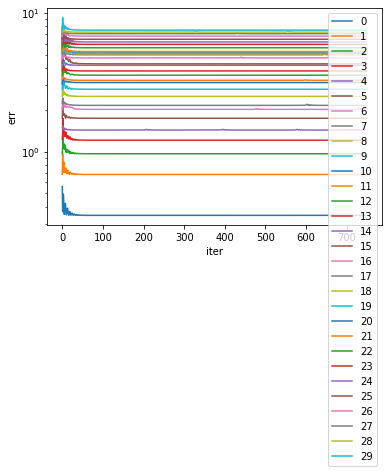

In [49]:
norms_list, norms_list_old, loss_dyns, gates_list, hidden_set = get_states_norm(30, 777)

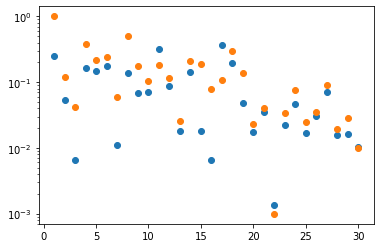

In [50]:
plt.scatter(np.arange(30) + 1, norms_list, color='#1f77b4')
plt.scatter(np.arange(30) + 1, norms_list_old, color='#ff7f0e')
plt.yscale('log')

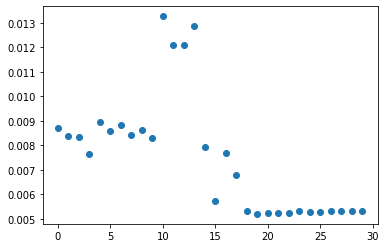

In [51]:
gate_norms_mean = []

for i in range(30):
    mean_norm = tf.reduce_mean(my_norm_set(gates_list[i],hidden_set), axis=0)
    #mean_norm = tf.reduce_mean(tf.linalg.norm((gates_list[i] - hidden_set), axis=(-2, -1)), axis=0)
    gate_norms_mean.append(mean_norm)

plt.scatter(range(30), gate_norms_mean)

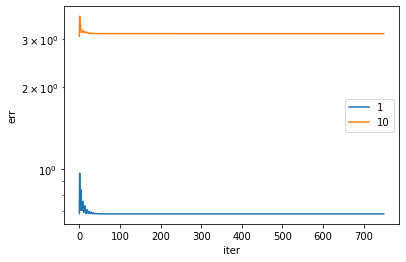

In [52]:
print_loss_dyn(loss_dyns[1], 1)
print_loss_dyn(loss_dyns[10], 10)

In [39]:
np.round(hidden_set, 5)

array([[[ 0.72467-0.02342j,  0.68645-0.05556j],
        [ 0.6869 -0.04976j, -0.71977+0.08735j]],

       [[ 0.83147-0.54958j,  0.01326-0.08034j],
        [ 0.01679-0.07968j,  0.57542+0.81379j]],

       [[ 0.88334-0.46535j, -0.01642+0.05379j],
        [ 0.03246+0.04593j,  0.98472+0.1648j ]]], dtype=complex64)

In [40]:
np.round(gates_list[23], 5)

array([[[ 0.63889-0.40847j,  0.6519 -0.00138j],
        [ 0.6519 +0.00138j, -0.63889-0.40847j]],

       [[ 0.41848-0.87225j, -0.09681-0.23384j],
        [ 0.09681-0.23384j,  0.41848+0.87225j]],

       [[ 0.71542-0.65666j,  0.0934 +0.21964j],
        [-0.0934 +0.21964j,  0.71543+0.65666j]]], dtype=complex64)

In [41]:
plt.scatter(tf.constant([0, 1, 2,]), gate_norms_list[14])

NameError: name 'gate_norms_list' is not defined